<a href="https://colab.research.google.com/github/mahemon/PySpark-practice/blob/main/data_plot_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download and install Spark

In [79]:
!pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [80]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark



#Setup environment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.net/deadsnake

In [105]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

import seaborn as sns
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
# read
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/s3')
# write
# df.to_parquet('my_newfile.parquet')
df.head()

,journeyId,cst-time,accelerationType,next_diff,Speed_Rate,breaking
0,T06AE661C1633071076575_1_4,2021-10-01 01:13:58,HARD_ACCELERATION,114.22,0.42,0
1,T06AE661C1633071076575_1_4,2021-10-01 01:18:33,None,-1.51,-0.06,0
2,T06AE661C1633071076575_1_4,2021-10-01 01:18:58,None,0.84,0.06,0
3,T06AE661C1633071076575_1_4,2021-10-01 01:19:12,None,-0.84,-0.21,0
4,T06AE661C1633071076575_1_4,2021-10-01 01:19:16,None,1.35,0.45,0


In [100]:
ndf = df[df['Speed_Rate'] < 10]
ndf = ndf[ndf['Speed_Rate'] > -10]

In [101]:
ndf=ndf.rename(columns={"cst-time": "csttime"})

In [102]:
ndf['Dates'] = pd.to_datetime(ndf['csttime']).dt.date
ndf['csttime'] = pd.to_datetime(ndf['csttime']).dt.time

In [103]:
ndf.head()

,journeyId,csttime,accelerationType,next_diff,Speed_Rate,breaking,Dates
0,T06AE661C1633071076575_1_4,01:13:58,HARD_ACCELERATION,114.22,0.42,0,2021-10-01
1,T06AE661C1633071076575_1_4,01:18:33,None,-1.51,-0.06,0,2021-10-01
2,T06AE661C1633071076575_1_4,01:18:58,None,0.84,0.06,0,2021-10-01
3,T06AE661C1633071076575_1_4,01:19:12,None,-0.84,-0.21,0,2021-10-01
4,T06AE661C1633071076575_1_4,01:19:16,None,1.35,0.45,0,2021-10-01


In [117]:
ndf=ndf.drop(columns=['journeyId', 'accelerationType'])

In [122]:
ndf.head(10)

,csttime,next_diff,Speed_Rate,breaking,Dates
0,01:13:58,114.22,0.42,0,2021-10-01
1,01:18:33,-1.51,-0.06,0,2021-10-01
2,01:18:58,0.84,0.06,0,2021-10-01
3,01:19:12,-0.84,-0.21,0,2021-10-01
4,01:19:16,1.35,0.45,0,2021-10-01
5,01:19:19,-3.17,-0.32,0,2021-10-01
6,01:19:29,2.66,0.05,0,2021-10-01
7,01:20:25,-2.99,-0.11,0,2021-10-01
8,01:20:52,2.99,0.05,0,2021-10-01
9,01:21:57,-1.67,-0.08,0,2021-10-01


Text(0.5, 1.0, 'time vs speed')

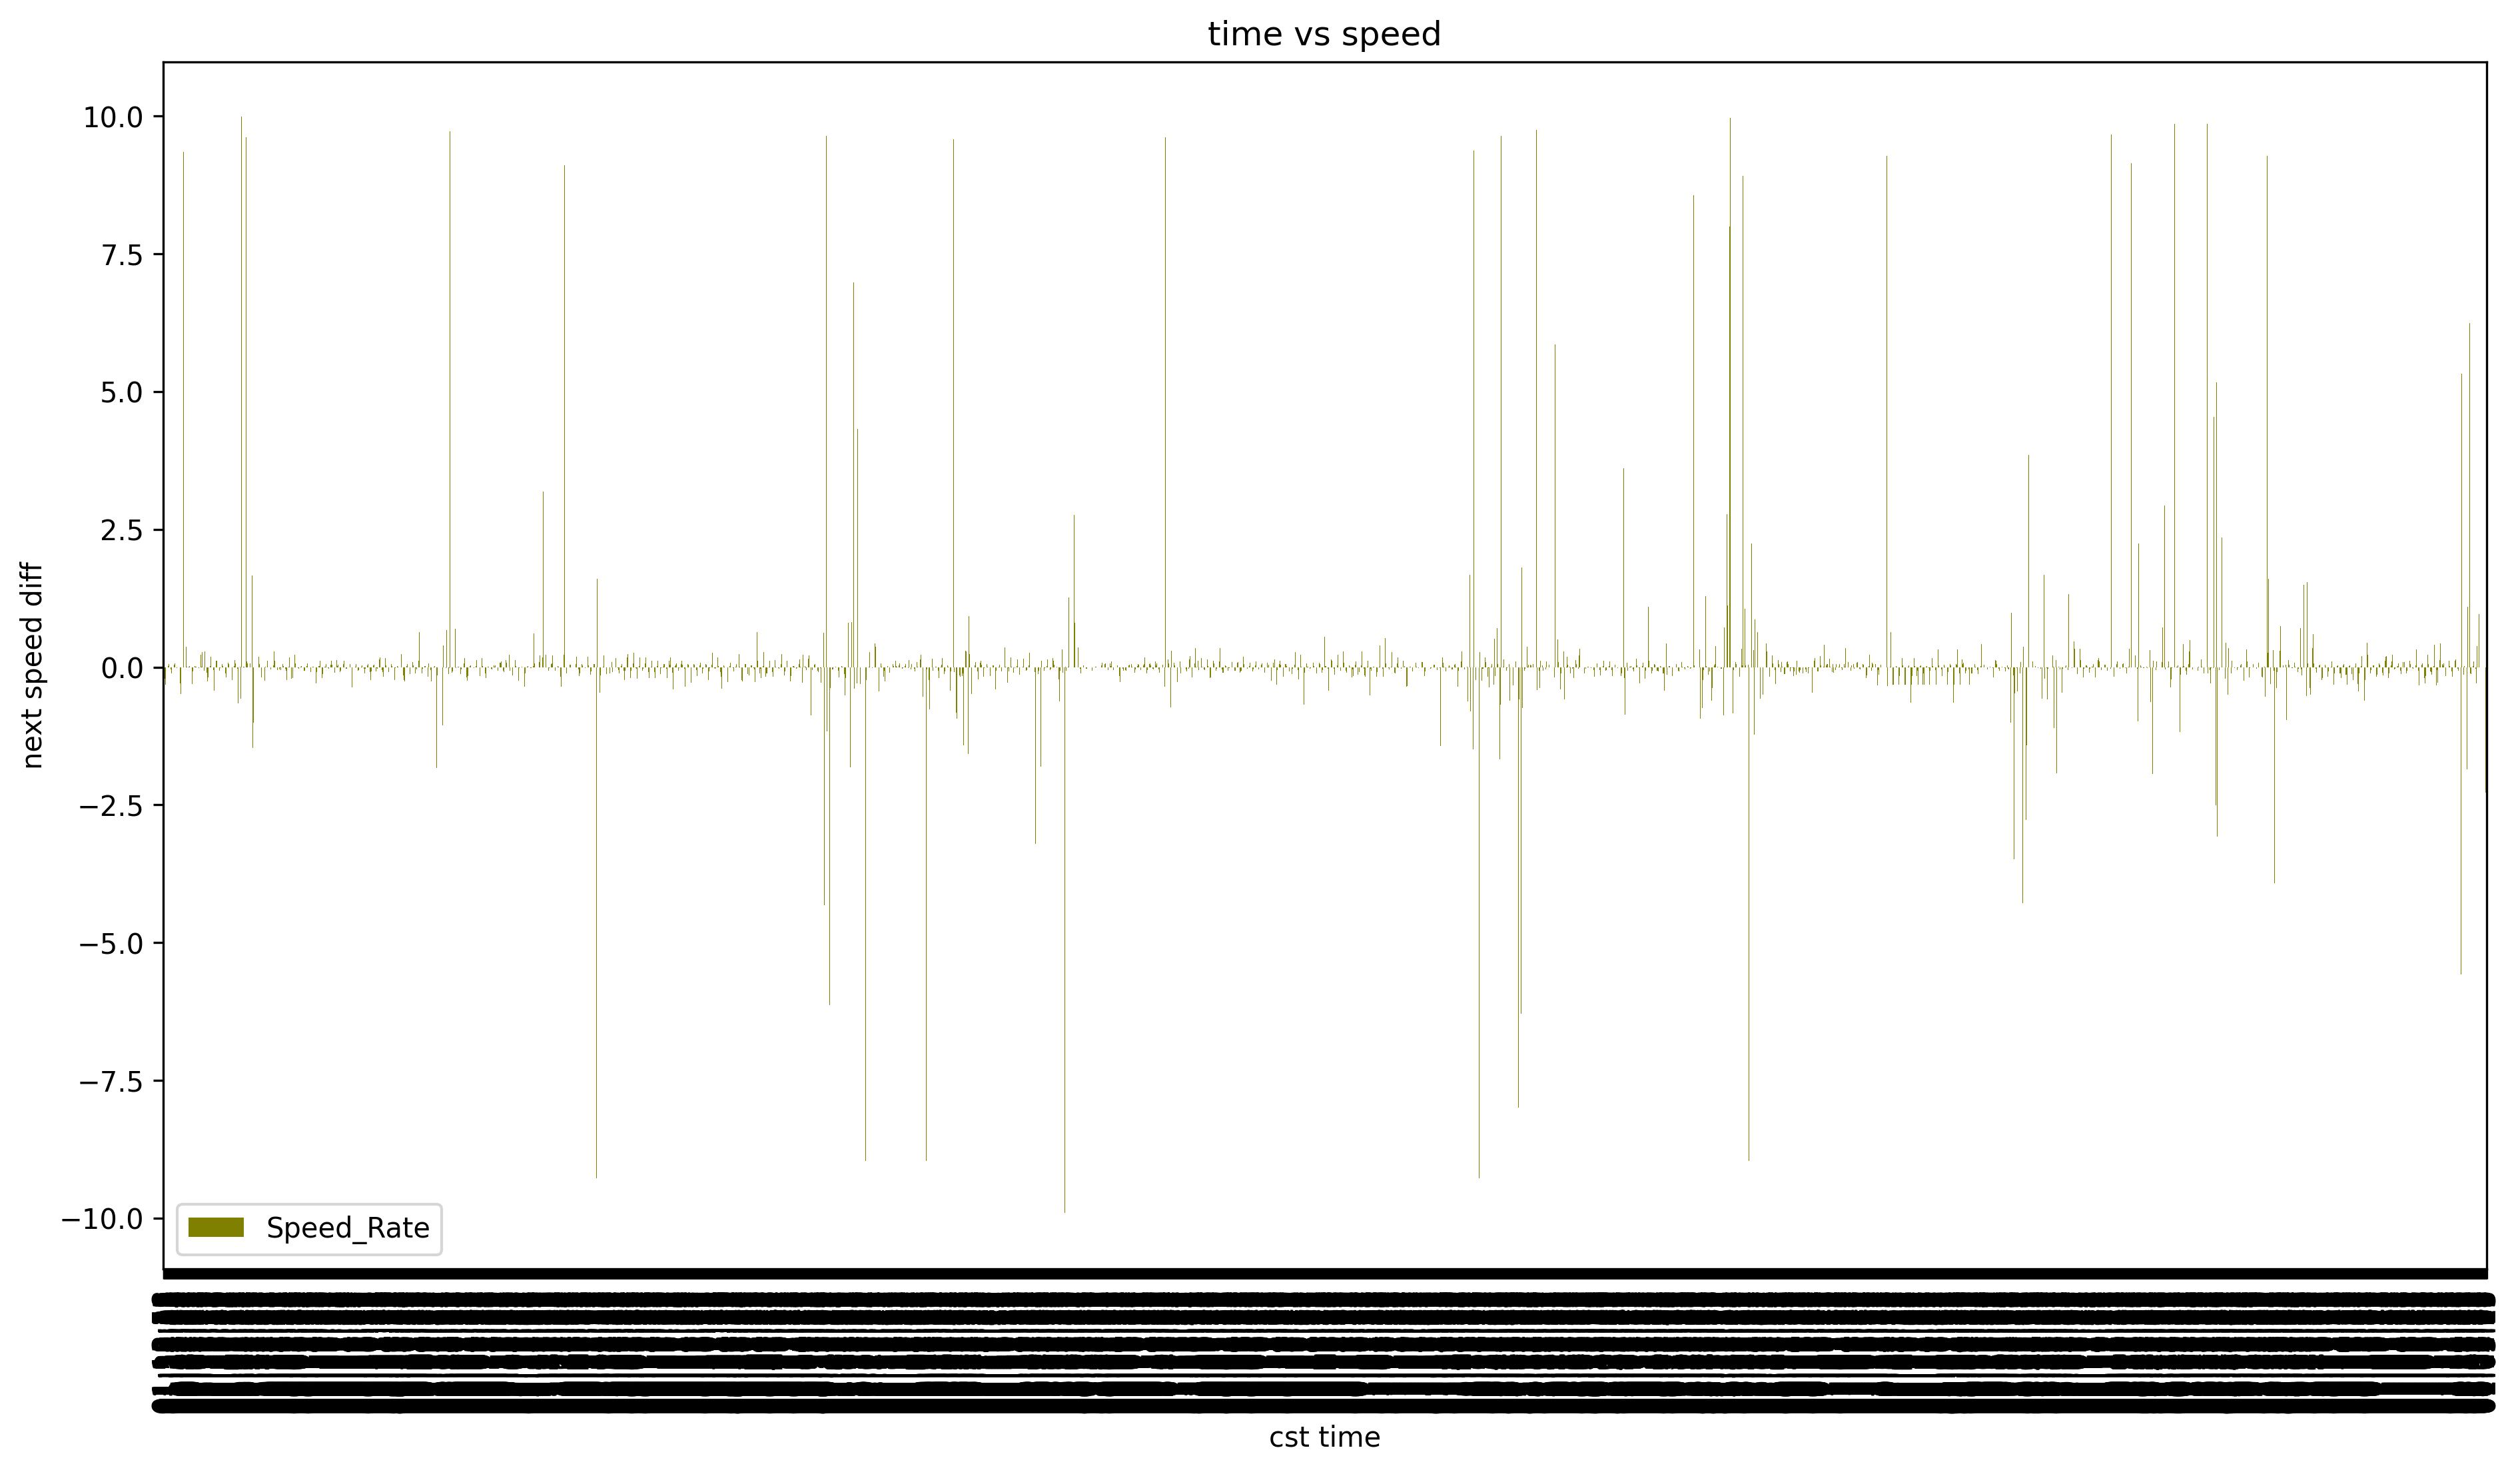

In [114]:
ndf.plot(kind='bar', color='olive', x ='csttime', y ='Speed_Rate',figsize=(15, 8))
plt.xlabel('cst time')
plt.ylabel('next speed diff')
plt.title('time vs speed')

In [108]:
print(ndf["csttime"].min())
print(ndf["csttime"].max())

00:00:01
03:59:59


In [109]:
#ndf['workingday'] = ndf['csttime'].astype('float')

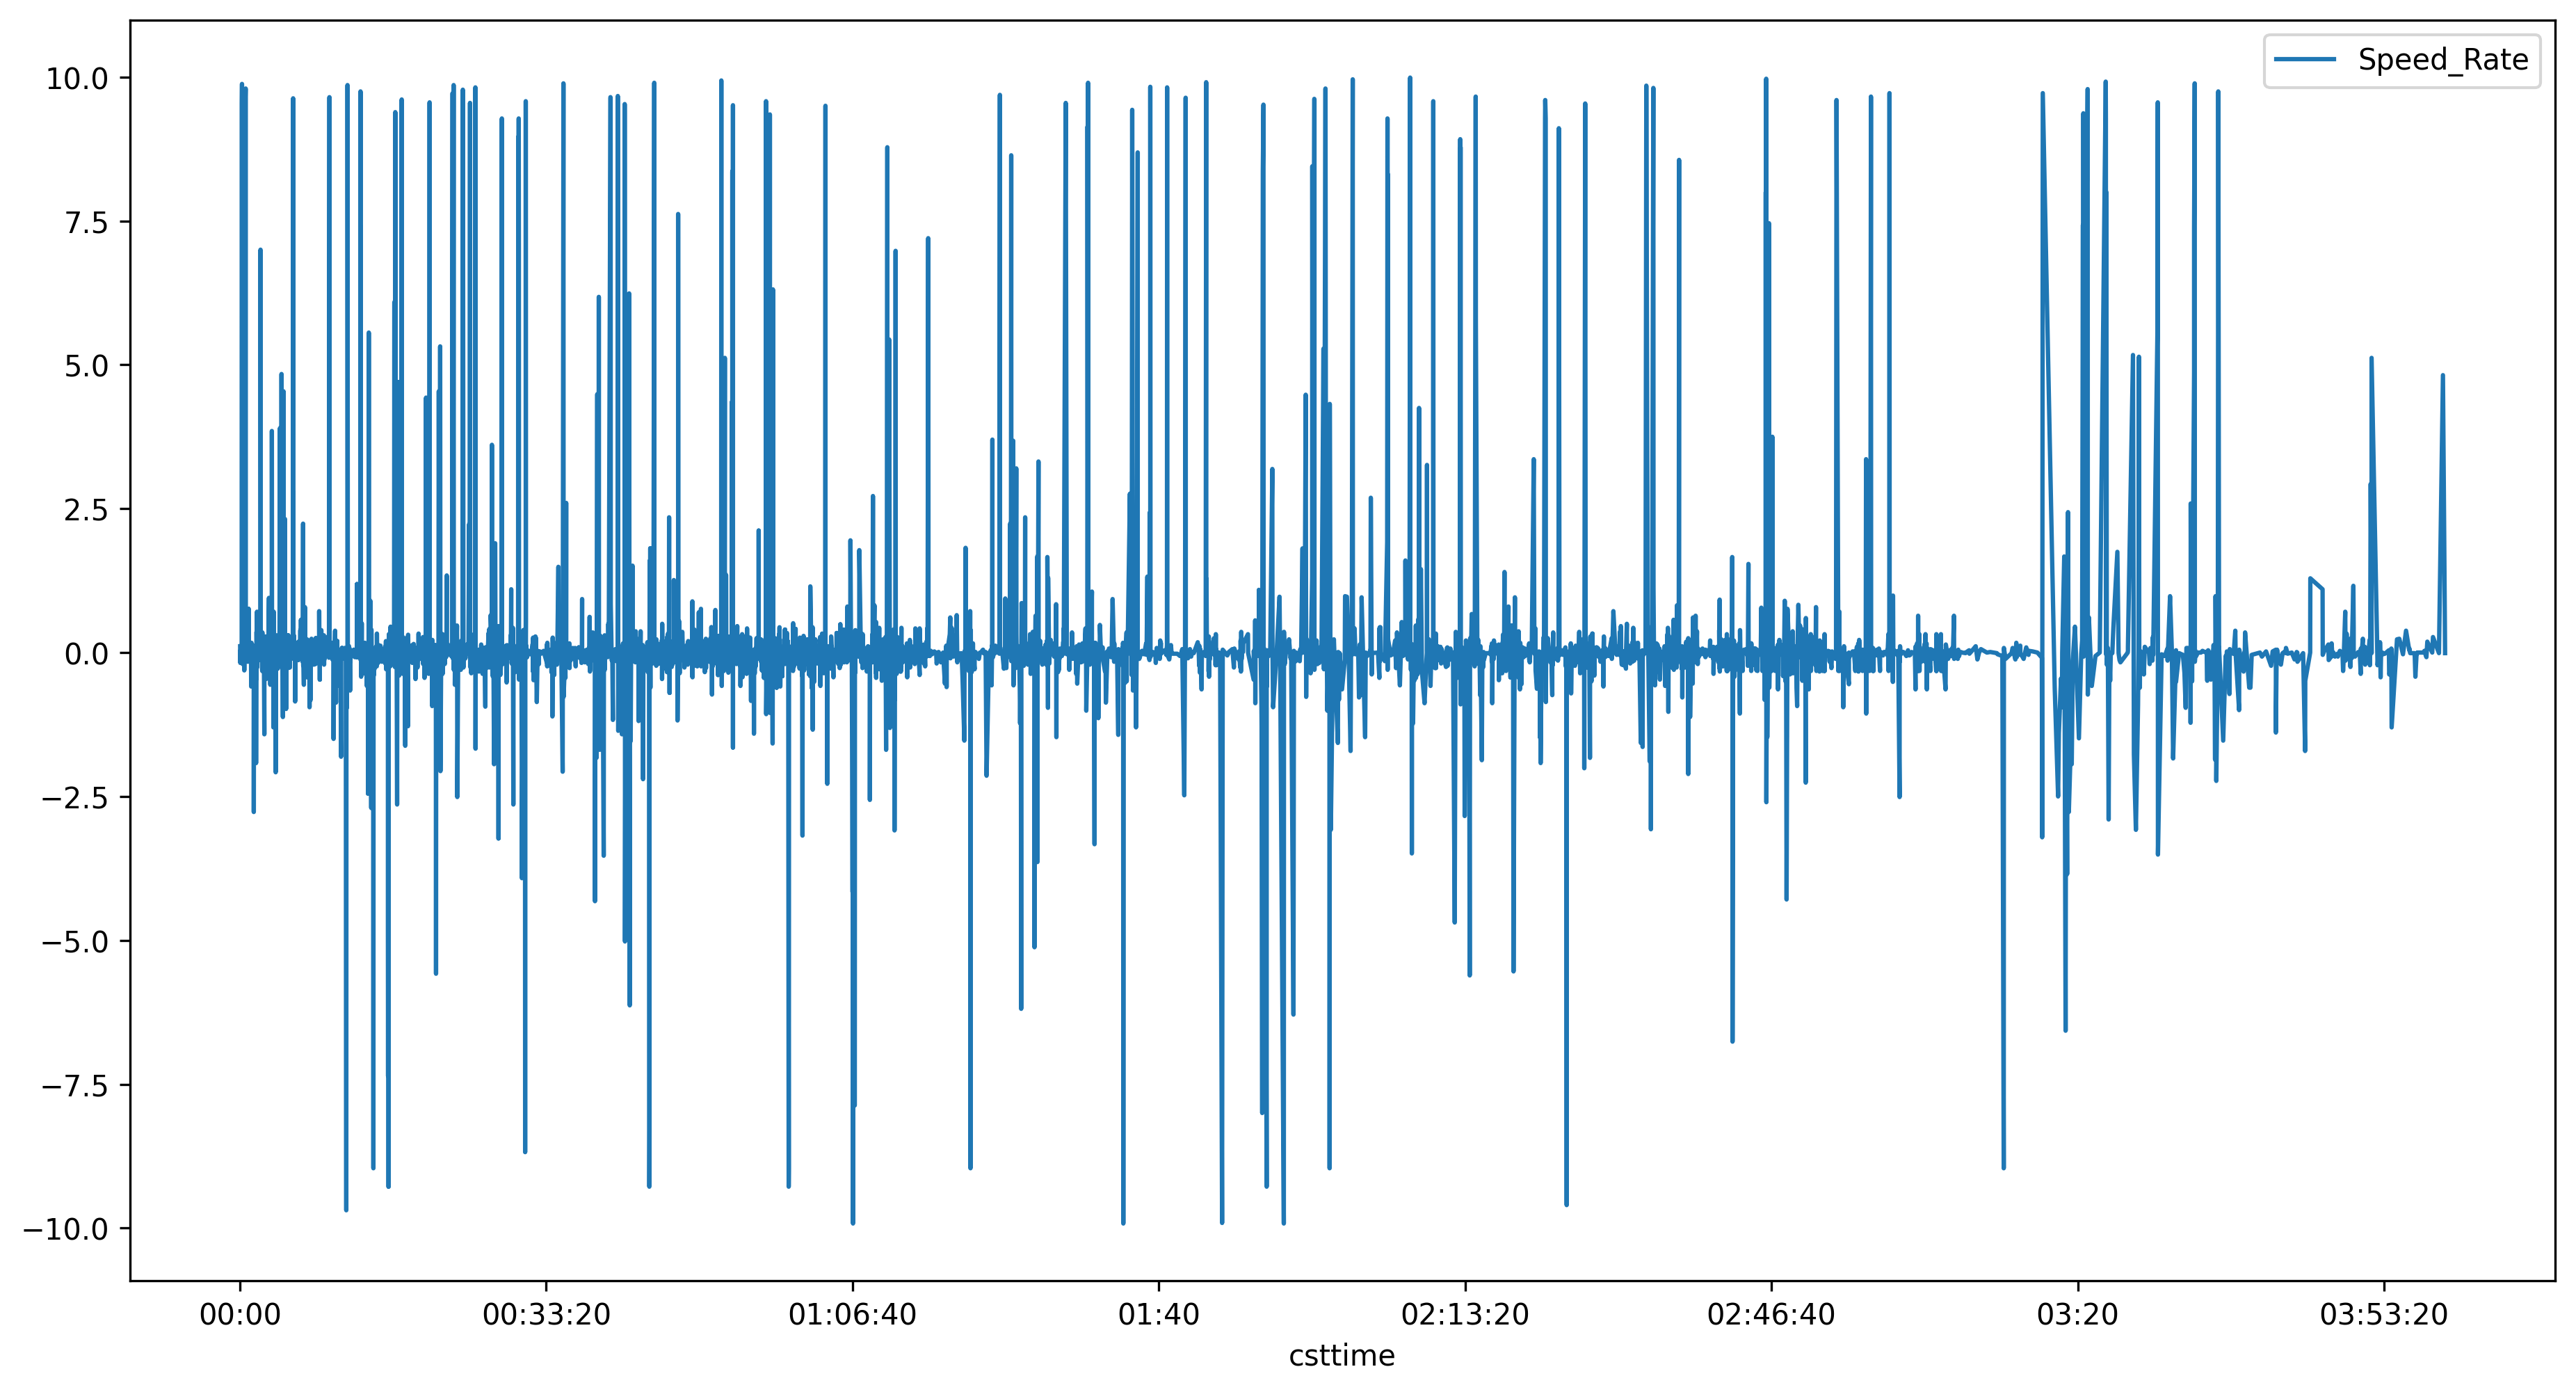

In [110]:
ndf.plot(x='csttime', y='Speed_Rate', figsize=(15, 8))

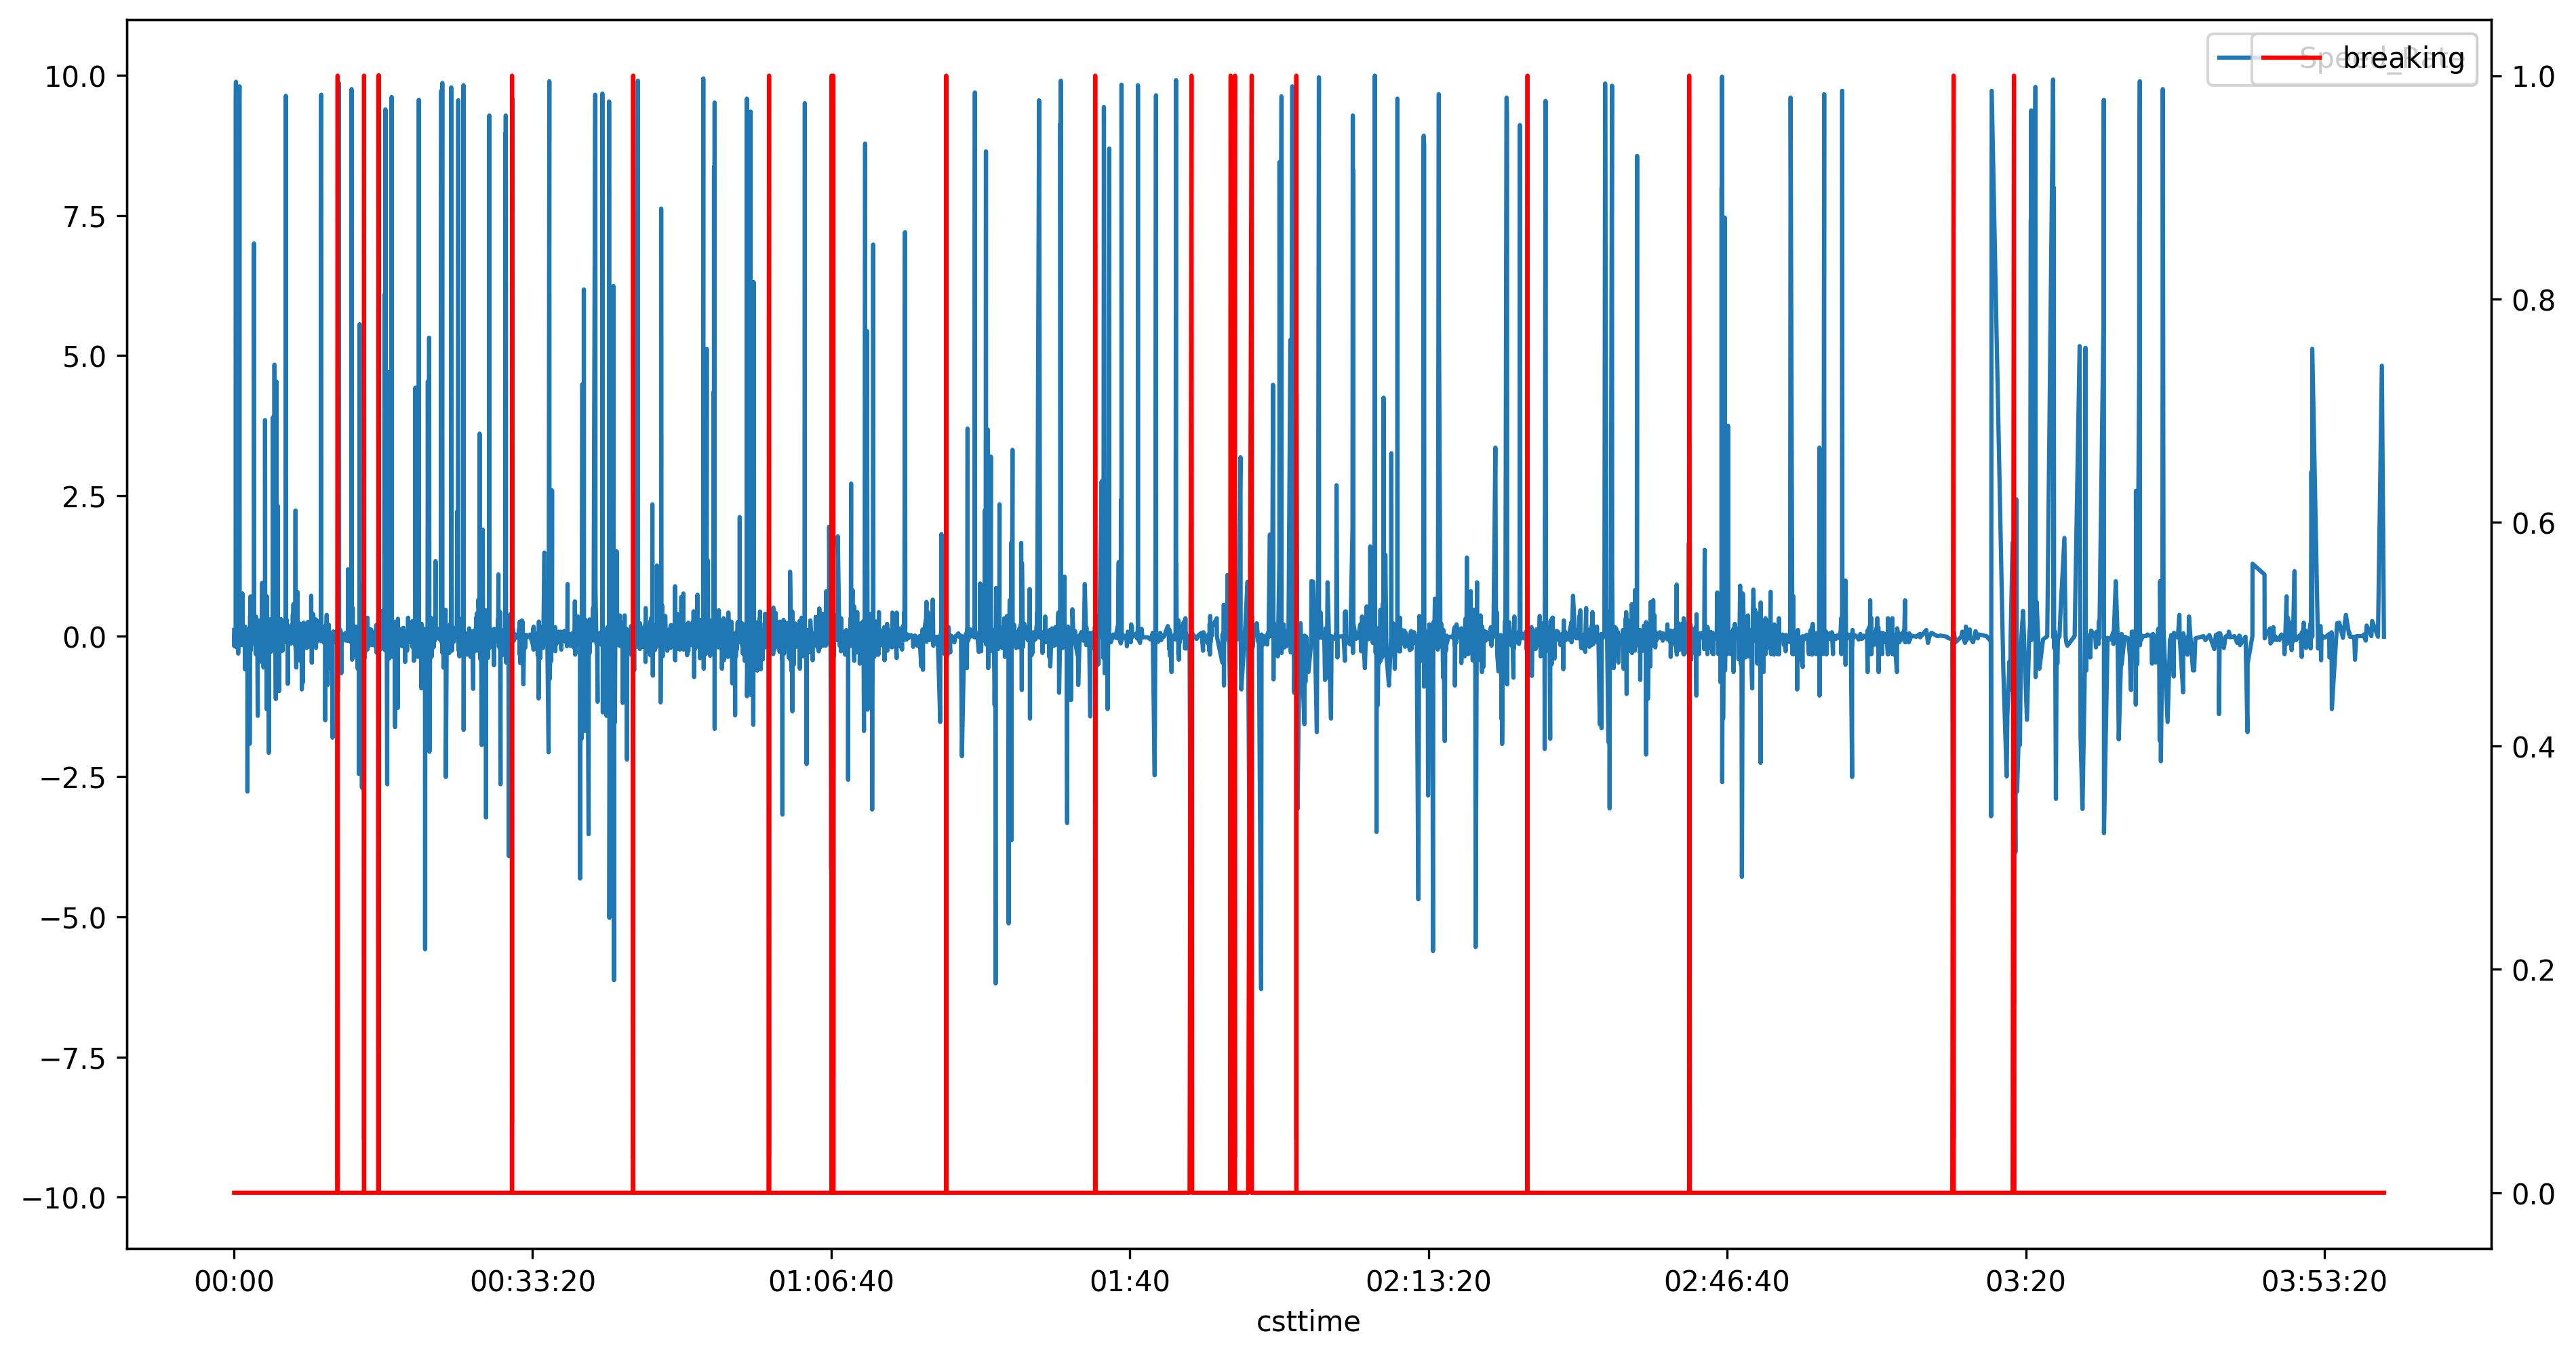

In [111]:
plt.figure(figsize=(15, 8))
ax = plt.gca()
ndf.plot(x='csttime', y='Speed_Rate', ax=ax);
ax2 = ax.twinx()
ndf.plot(x='csttime', y='breaking', color='red', ax=ax2);